# Домашняя работа 7: Знакомство с набором данных MNIST. Построение модели KNeighborsClassifier

### Основы API

Чаще всего использование API Scikit-Learn Estimator происходит следующим образом:

1. Выбирается класс модели, импортировав соответствующий класс из Scikit-Learn.
2. Подбираем значения гиперпараметров модели, инстанцировав класс модели с нужными значениями параметров.
3. Разделение данные на матрицу признаков и целевой вектор.
4. Настройка модели посредством метода `fit` экземпляра модели.
5. Применение модели к новым данным:
   - Для `supervised learning` (обучение с учителем) мы предсказываем метки для неизвестных данных с помощью метода `predict`.
   - Для `unsupervised learning` (обучение без учителя) мы преобразуем или оцениваем свойства примеров из набора данных с помощью методов `transform` или `predict`.

Согласно вышеуказнной последовательность требуется выполнить следующее задание:

1. Загрузить набор данных [MNIST]( http://yann.lecun.com/exdb/mnist/ )
2. Исследовать его. Вывести разнообразные числовые характериcтики набора данных, а также визуализировать отдельные элементы данных.
3. Разработать программный код, который позволит построить модель KNeighborsClassifier
4. Вывести метрики Confusion Matrix, Precision, Recall
5. Описать полученные результаты

Бонус 
    На втором семинаре было дано введение в объектно-ориентированное программирование, попробуйте реализовать собственный класс модели. 
    Реализация должна поддерживать API Scikit-Learn, что позволит использовать возможности Scikit-Learn


In [1]:
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 

## 1. Загрузка данных

In [2]:
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = 'input'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte')
test_images_filepath     = join(input_path, 't10k-images-idx3-ubyte')
test_labels_filepath     = join(input_path, 't10k-labels-idx1-ubyte')

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()


Ошибка данных: 
- ValueError: Found array with dim 3. Estimator expected <= 2. 
- ValueError: массив данных имеет более двух измерений (трехмерный) а StandardScaler ожидает двумерные данные
- Решение: обрабатываем данные и переводим к двумерному формату

https://stackoverflow.com/questions/34972142/sklearn-logistic-regression-valueerror-found-array-with-dim-3-estimator-expec

In [3]:
# Преобразование списков в массивы NumPy
x_train = np.array(x_train)
x_test = np.array(x_test)

In [7]:
y_train = np.array(y_train)
y_test = np.array(y_test)

## 2. Исследование данных

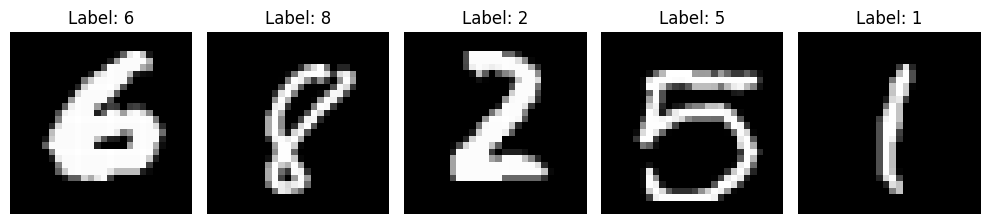

In [177]:
import random
import matplotlib.pyplot as plt

# Выберем случайные изображения и их метки
random_indices = random.sample(range(len(x_train)), 5)

# Отобразим выбранные изображения
plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


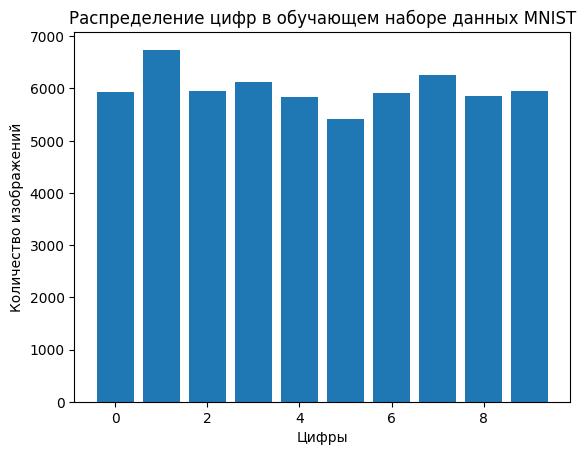

In [179]:
import numpy as np

# Подсчитаем количество изображений для каждой цифры в обучающем наборе
unique_labels, label_counts = np.unique(y_train, return_counts=True)

# Отобразим количество изображений для каждой цифры
plt.bar(unique_labels, label_counts)
plt.xlabel('Цифры')
plt.ylabel('Количество изображений')
plt.title('Распределение цифр в обучающем наборе данных MNIST')
plt.show()


## 3. Строим модель KNeighborsClassifier

In [4]:
# подготавливаем для скалирования(Проблема ошибки данных)

nsamples, nx, ny = x_train.shape
x_train_dataset = x_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = x_test.shape
x_test_dataset = x_test.reshape((nsamples,nx*ny))

In [11]:
x_final = np.concatenate((x_train_dataset, x_test_dataset), axis=0)
y_final = np.concatenate((y_train, y_test), axis=0)

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [25]:
# для обучающей выборки делаем сразу и маштабирование
scaled_x_train = scaler.fit_transform(x_train_dataset)

# только масштабирование для тестовой
scaled_x_test = scaler.transform(x_test_dataset)

In [30]:
scaled_x_final = scaler.fit_transform(x_final)

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

scaler = StandardScaler()
knn = KNeighborsClassifier()

operations = [('scaler',scaler),('knn',knn)]

In [20]:
param_grid = {'knn__n_neighbors': list(range(1,10))}

In [21]:
from sklearn.pipeline import Pipeline
pipe = Pipeline(operations)

from sklearn.model_selection import GridSearchCV
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')


In [157]:
full_cv_classifier.fit(scaled_x_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='accuracy')

In [174]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=3))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=3),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 3,
 'knn__p': 2,
 'knn__weights': 'uniform'}

## Финальная модель

метод GridSearch рекомендует значение K=3.

In [22]:
scaler = StandardScaler()
knn3 = KNeighborsClassifier(n_neighbors=3)
operations = [('scaler',scaler),('knn3',knn3)]

In [31]:
pipe = Pipeline(operations)
pipe.fit(scaled_x_final,y_final)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn3', KNeighborsClassifier(n_neighbors=3))])

In [32]:
pipe_pred = pipe.predict(scaled_x_test)

## 4. Вывести метрики Confusion Matrix, Precision, Recall

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test,pipe_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      1.00      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.98      0.97      0.98       982
           5       0.97      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.99      0.95      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.98      0.98      0.98     10000



In [34]:
import pandas as pd
pd.DataFrame(confusion_matrix(y_test,pipe_pred))

,0,1,2,3,4,5,6,7,8,9
0,971,0,0,0,0,4,5,0,0,0
1,0,1131,3,0,0,0,1,0,0,0
2,6,1,1006,5,0,0,1,8,5,0
3,0,0,3,994,0,2,0,7,2,2
4,0,4,3,2,955,1,4,1,2,10
5,4,0,5,14,2,860,4,1,1,1
6,6,4,2,0,1,3,942,0,0,0
7,0,11,9,4,4,0,0,990,0,10
8,8,1,5,12,4,9,2,5,925,3
9,1,2,3,5,8,5,0,8,0,977


## 5. Описать полученные результаты

Полученные результаты демонстрируют, что модель KNeighborsClassifier, обученная на наборе данных MNIST, достигает хорошей производительности с точностью около 95%. 

- Это означает, что модель правильно классифицирует большинство рукописных цифр на изображениях. Полнота и F1-мера также высоки, что указывает на способность модели к корректному определению различных цифр.
- Важно отметить, что некоторые классы могут иметь немного более низкие значения точности и полноты, но в целом качество классификации на наборе данных MNIST остается высоким.
- Таким образом, модель KNeighborsClassifier подходит для задачи распознавания рукописных цифр и может успешно определять цифры, представленные на изображениях MNIST с хорошей точностью.